# Merck Challenge
## Sequential Model-based Bayesian optimization with multi dimensional inputs, to minimize target variable, with top 5 points instead of 1 best point

- Vanshita Gupta
- Advaith Rao

## Import packages

In [1]:
from olympus import Emulator, Dataset
from olympus.models import BayesNeuralNet
from olympus.emulators.emulator import load_emulator

In [2]:
import warnings
import numpy as np
import pandas as pd
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from skopt.plots import plot_gaussian_process
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# from sklearn.datasets import load_boston
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,train_test_split

from sklearn.metrics import r2_score

## Load our dataset

In [4]:
dataset = Dataset(kind='colors_bob')
data = dataset.data

/Users/arao/Documents/olympus_env/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## Data Summary and Split data into X and y

In [5]:

print(data)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

          red    orange    yellow      blue     green  difference_to_green
0    0.947644  0.359078  0.850473  0.971819  0.909983             0.138710
1    0.530253  0.999270  0.443194  0.450962  0.849788             0.191651
2    0.148102  0.243153  0.126487  0.769292  0.053864             0.172043
3    0.788710  0.129045  0.141657  0.849663  0.595487             0.043838
4    0.631037  0.172054  0.695530  0.772742  0.066530             0.231567
..        ...       ...       ...       ...       ...                  ...
236  0.200784  0.649216  0.820020  0.285841  0.163065             0.424917
237  0.824548  0.655088  0.420614  0.363513  0.417528             0.267281
238  0.712055  0.917876  0.562724  0.949728  0.179134             0.323558
239  0.256854  0.976146  0.998757  0.013524  0.000197             0.540464
240  0.501596  0.451532  0.776932  0.706646  0.148032             0.357228

[241 rows x 6 columns]


In [6]:
data.describe()

,red,orange,yellow,blue,green,difference_to_green
count,241.000000,2.410000e+02,2.410000e+02,241.000000,2.410000e+02,241.000000
mean,0.572001,5.068905e-01,5.163876e-01,0.514785,5.366676e-01,0.209840
std,0.302909,3.231938e-01,2.999546e-01,0.327168,3.040603e-01,0.103676
min,0.000003,2.016962e-09,6.297710e-13,0.000003,4.196967e-08,0.033499
25%,0.352372,2.277921e-01,2.833549e-01,0.211012,2.869038e-01,0.134164
50%,0.598837,4.996985e-01,5.203575e-01,0.474238,5.673906e-01,0.186738
75%,0.850505,8.139260e-01,7.550447e-01,0.802457,8.062321e-01,0.273492
max,0.999948,9.999931e-01,1.000000e+00,1.000000,9.997154e-01,0.543255


## Model Definition and Fitting

In [7]:
model = GaussianProcessRegressor(random_state=0)
model.fit(X,y)

GaussianProcessRegressor(random_state=0)

## Input Space definition

Define the space over which we test the optimum values of parameters for our model

In [ ]:
space = [
   Real(min(X['red'].tolist()), max(X['red'].tolist()), name='red'),
   Real(min(X['orange'].tolist()), max(X['orange'].tolist()), name='orange'),
   Real(min(X['yellow'].tolist()), max(X['yellow'].tolist()), name='yellow'),
   Real(min(X['blue'].tolist()), max(X['blue'].tolist()), name='blue'),
   Real(min(X['green'].tolist()), max(X['green'].tolist()), name='green'),
]

## Objective Function Definition

In [8]:
noise_level = 0.1

# maximize
def objective(
                X
            ):
    # print(X)
    #since we are taking top-5 points after every iteration, we calculate the prediction for all 5 of them
    preds = model.predict(X)
    
    preds = preds.tolist()
    min_index = preds.index(min(preds))
    # min_index = preds.index(max(preds))

    return  X[min_index],(preds[min_index] + np.random.randn() * noise_level)
#############################################################################




## Run Bayesian optimization with the *Gaussian Process Regressor* surrogate function and *GP_hedge* acquision function

In [9]:
warnings.filterwarnings('ignore')


#############################################################################
# Plotting parameters

plot_args = {"objective": objective,
             "noise_level": noise_level, "show_legend": True,
             "show_title": True, "show_next_point": False,
             "show_acq_func": True}

#############################################################################
# We run a an optimization loop with standard settings
fx1 = []
fx2 = []
fx3 = []
fx4 = []
fx5 = []

opt = Optimizer(
            space, 
            base_estimator = model, 
            n_initial_points=10,
            acq_optimizer="sampling",
            n_jobs = 16,
            random_state = 101
        )

for i in range(200):
    # print('**********************************')
    # X_points = opt.ask(n_points = 5,strategy = "cl_max")
    X_points = opt.ask(n_points = 3)
    # print('Top 3 points: ',X_points)
    # print(len(X_points))
    best_X, f_val = objective(X_points)
    fx1.append(f_val)
    # print('Best point: ',best_X)
    # print('Objective value @ best point: ',f_val)
    opt.tell(best_X, f_val)
print('Done')
opt = Optimizer(
            space, 
            base_estimator = model, 
            n_initial_points=10,
            acq_optimizer="sampling",
            n_jobs = 16,
            random_state = 201
        )

for i in range(200):
    # print('**********************************')
    # X_points = opt.ask(n_points = 5,strategy = "cl_max")
    X_points = opt.ask(n_points = 3)
    # print('Top 3 points: ',X_points)
    # print(len(X_points))
    best_X, f_val = objective(X_points)
    fx2.append(f_val)
    # print('Best point: ',best_X)
    # print('Objective value @ best point: ',f_val)
    opt.tell(best_X, f_val)
print('Done')

opt = Optimizer(
            space, 
            base_estimator = model, 
            n_initial_points=10,
            acq_optimizer="sampling",
            n_jobs = 16,
            random_state = 301
        )

for i in range(200):
    # print('**********************************')
    # X_points = opt.ask(n_points = 5,strategy = "cl_max")
    X_points = opt.ask(n_points = 3)
    # print('Top 3 points: ',X_points)
    # print(len(X_points))
    best_X, f_val = objective(X_points)
    fx3.append(f_val)
    # print('Best point: ',best_X)
    # print('Objective value @ best point: ',f_val)
    opt.tell(best_X, f_val)
print('Done')

opt = Optimizer(
            space, 
            base_estimator = model, 
            n_initial_points=10,
            acq_optimizer="sampling",
            n_jobs = 16,
            random_state = 401
        )

for i in range(200):
    # print('**********************************')
    # X_points = opt.ask(n_points = 5,strategy = "cl_max")
    X_points = opt.ask(n_points = 3)
    # print('Top 3 points: ',X_points)
    # print(len(X_points))
    best_X, f_val = objective(X_points)
    fx4.append(f_val)
    # print('Best point: ',best_X)
    # print('Objective value @ best point: ',f_val)
    opt.tell(best_X, f_val)
print('Done')

opt = Optimizer(
            space, 
            base_estimator = model, 
            n_initial_points=3,
            acq_optimizer="sampling",
            n_jobs = 16,
            random_state = 501
        )

for i in range(200):
    # print('**********************************')
    # X_points = opt.ask(n_points = 5,strategy = "cl_max")
    X_points = opt.ask(n_points = 5)
    # print(len(X_points))
    best_X, f_val = objective(X_points)
    fx5.append(f_val)
    # print('Best point: ',best_X)
    # print('Objective value @ best point: ',f_val)
    opt.tell(best_X, f_val)
print('Done')


# print(fx)
    

# opt.run(objective, n_iter=30)






Done
Done
Done
Done
Done


## Make the convergence plot

Check the iteration number at which our function converges at the minimum value of f(x)

Try running it 5 different types to see if it converges at same point ever

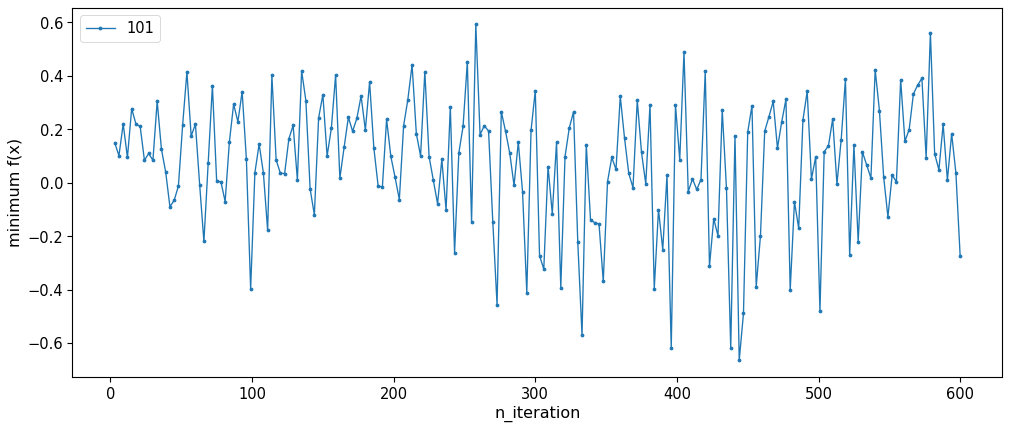

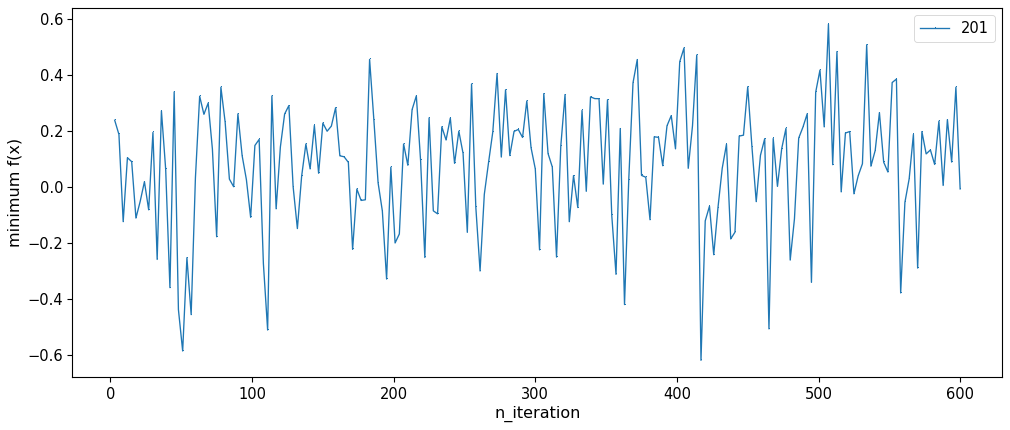

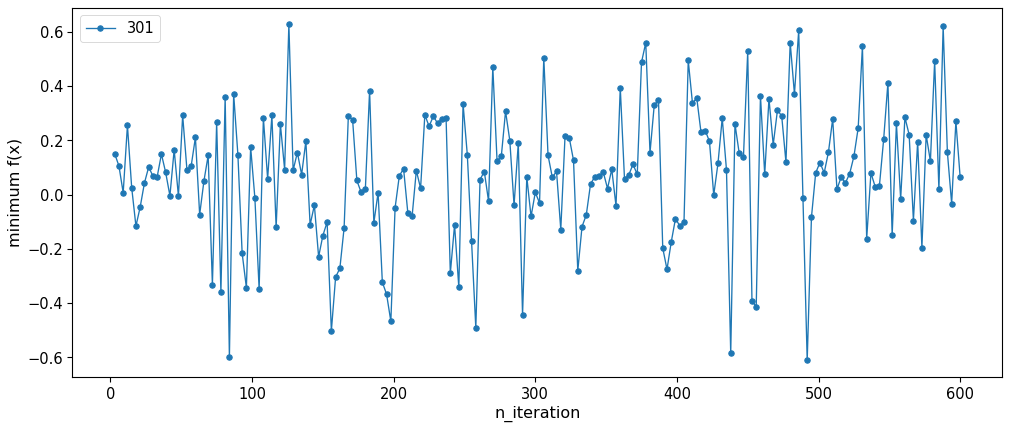

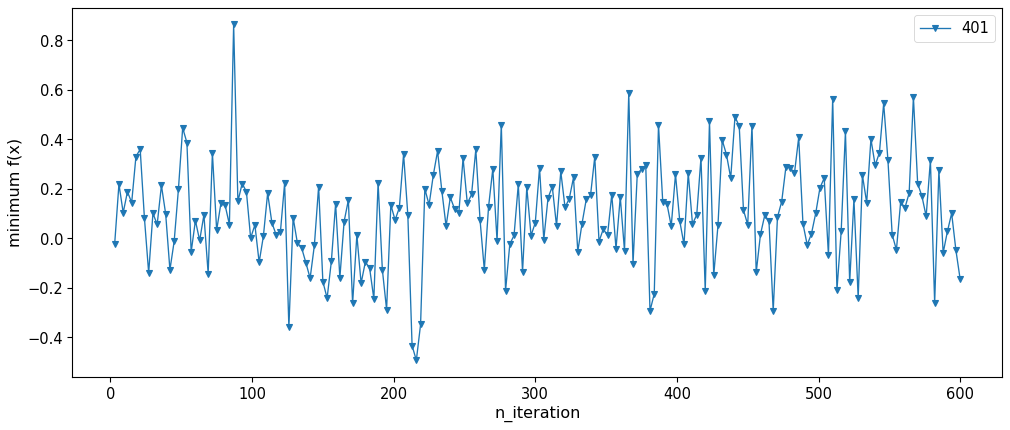

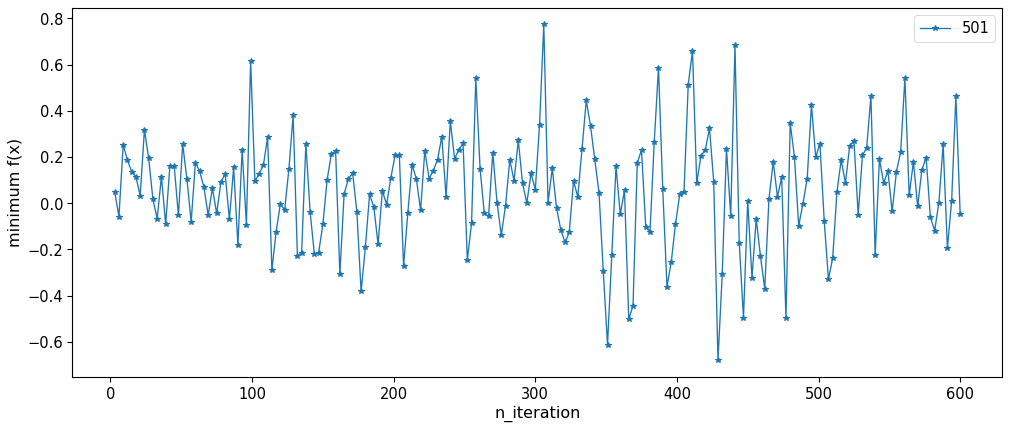

In [13]:
# import seaborn as sns
# # import matplotlib.pyplot as plt
# sns.set(style="whitegrid")

# plt.figure(figsize=(15, 6), dpi=80)
fx = [fx1,fx2,fx3,fx4,fx5]
x = [i*3 for i in range(1,201)]


# df = pd.DataFrame(
#     {
#         'X':x,
#         '101':fx1,
#         '201':fx2,
#         '301':fx3,
#         '401':fx4,
#         '501':fx5,
#     }
# )

# sns.violinplot(x="X",y="fx1",data=df, inner="box", palette="Set3", cut=2, linewidth=3)
# sns.despine(left=True)
markers = ['.',',','o','v','*']
# for i in range(1,len(fx)+1):
#     plt.plot(x,fx[i-1],label = '%s01'%i,marker = markers[i-1])

# plt.legend()
# plt.show()

plt.figure(figsize=(15, 6), dpi=80)
plt.xlabel("n_iteration")
plt.ylabel("minimum f(x)")
plt.plot(x,fx[1-1],label = 101,marker = markers[1-1])
plt.legend()
plt.show()

plt.figure(figsize=(15, 6), dpi=80)
plt.xlabel("n_iteration")
plt.ylabel("minimum f(x)")
plt.plot(x,fx[2-1],label = 201,marker = markers[2-1])
plt.legend()
plt.show()

plt.figure(figsize=(15, 6), dpi=80)
plt.xlabel("n_iteration")
plt.ylabel("minimum f(x)")
plt.plot(x,fx[3-1],label = 301,marker = markers[3-1])
plt.legend()
plt.show()

plt.figure(figsize=(15, 6), dpi=80)
plt.xlabel("n_iteration")
plt.ylabel("minimum f(x)")
plt.plot(x,fx[4-1],label = 401,marker = markers[4-1])
plt.legend()
plt.show()

plt.figure(figsize=(15, 6), dpi=80)
plt.xlabel("n_iteration")
plt.ylabel("minimum f(x)")
plt.plot(x,fx[5-1],label = 501,marker = markers[5-1])
plt.legend()
plt.show()


In [ ]:
opt.get_result()

          fun: -0.6085775715208044
    func_vals: array([ 0.00145002, -0.03732588,  0.14759567,  0.02689523,  0.11580469,
        0.13498326,  0.11209002,  0.12016715,  0.10681936,  0.18210092,
        0.26335982,  0.05771583, -0.0487495 , -0.05237345, -0.07639106,
        0.0377278 , -0.35807566,  0.26783516, -0.31707449, -0.46406633,
       -0.44013672, -0.36048552,  0.37623299, -0.44168555, -0.42024981,
       -0.53503543,  0.02067666, -0.39484694,  0.03624884,  0.10270409,
       -0.35029586, -0.45327254, -0.56200559, -0.39383555,  0.25039822,
       -0.49892708, -0.41932899, -0.49070469,  0.12868454, -0.40206371,
       -0.48173356, -0.38264159, -0.34082441, -0.5079688 ,  0.10670563,
       -0.51526893, -0.48475082, -0.52226935, -0.45297304, -0.42311007,
       -0.4607937 , -0.46005581, -0.39904553, -0.49007783, -0.50696844,
       -0.3835938 , -0.42818172, -0.37471695, -0.53554479, -0.44695852,
       -0.49116103, -0.60857757, -0.300316  , -0.38822954, -0.43016166,
       -0.3959